In [1]:
import sys

sys.path.append("../")

import nt2.read as nt2r
import myplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.optimize import fsolve

myplotlib.load("hershey")


def coloredLine(x, y, c, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    for i in range(len(x) - 1):
        ax.plot(x[i : i + 2], y[i : i + 2], c=c[i], **kwargs)


def energy(ur, uph, r, a):
    return -(
        2 * np.sqrt(r) * ur
        - np.sqrt(
            2 * r**2
            + 2 * (uph + a * ur) ** 2
            + r * (uph + a * ur) ** 2
            + r**3 * (1 + ur**2)
        )
    ) / (np.sqrt(r) * (2 + r))

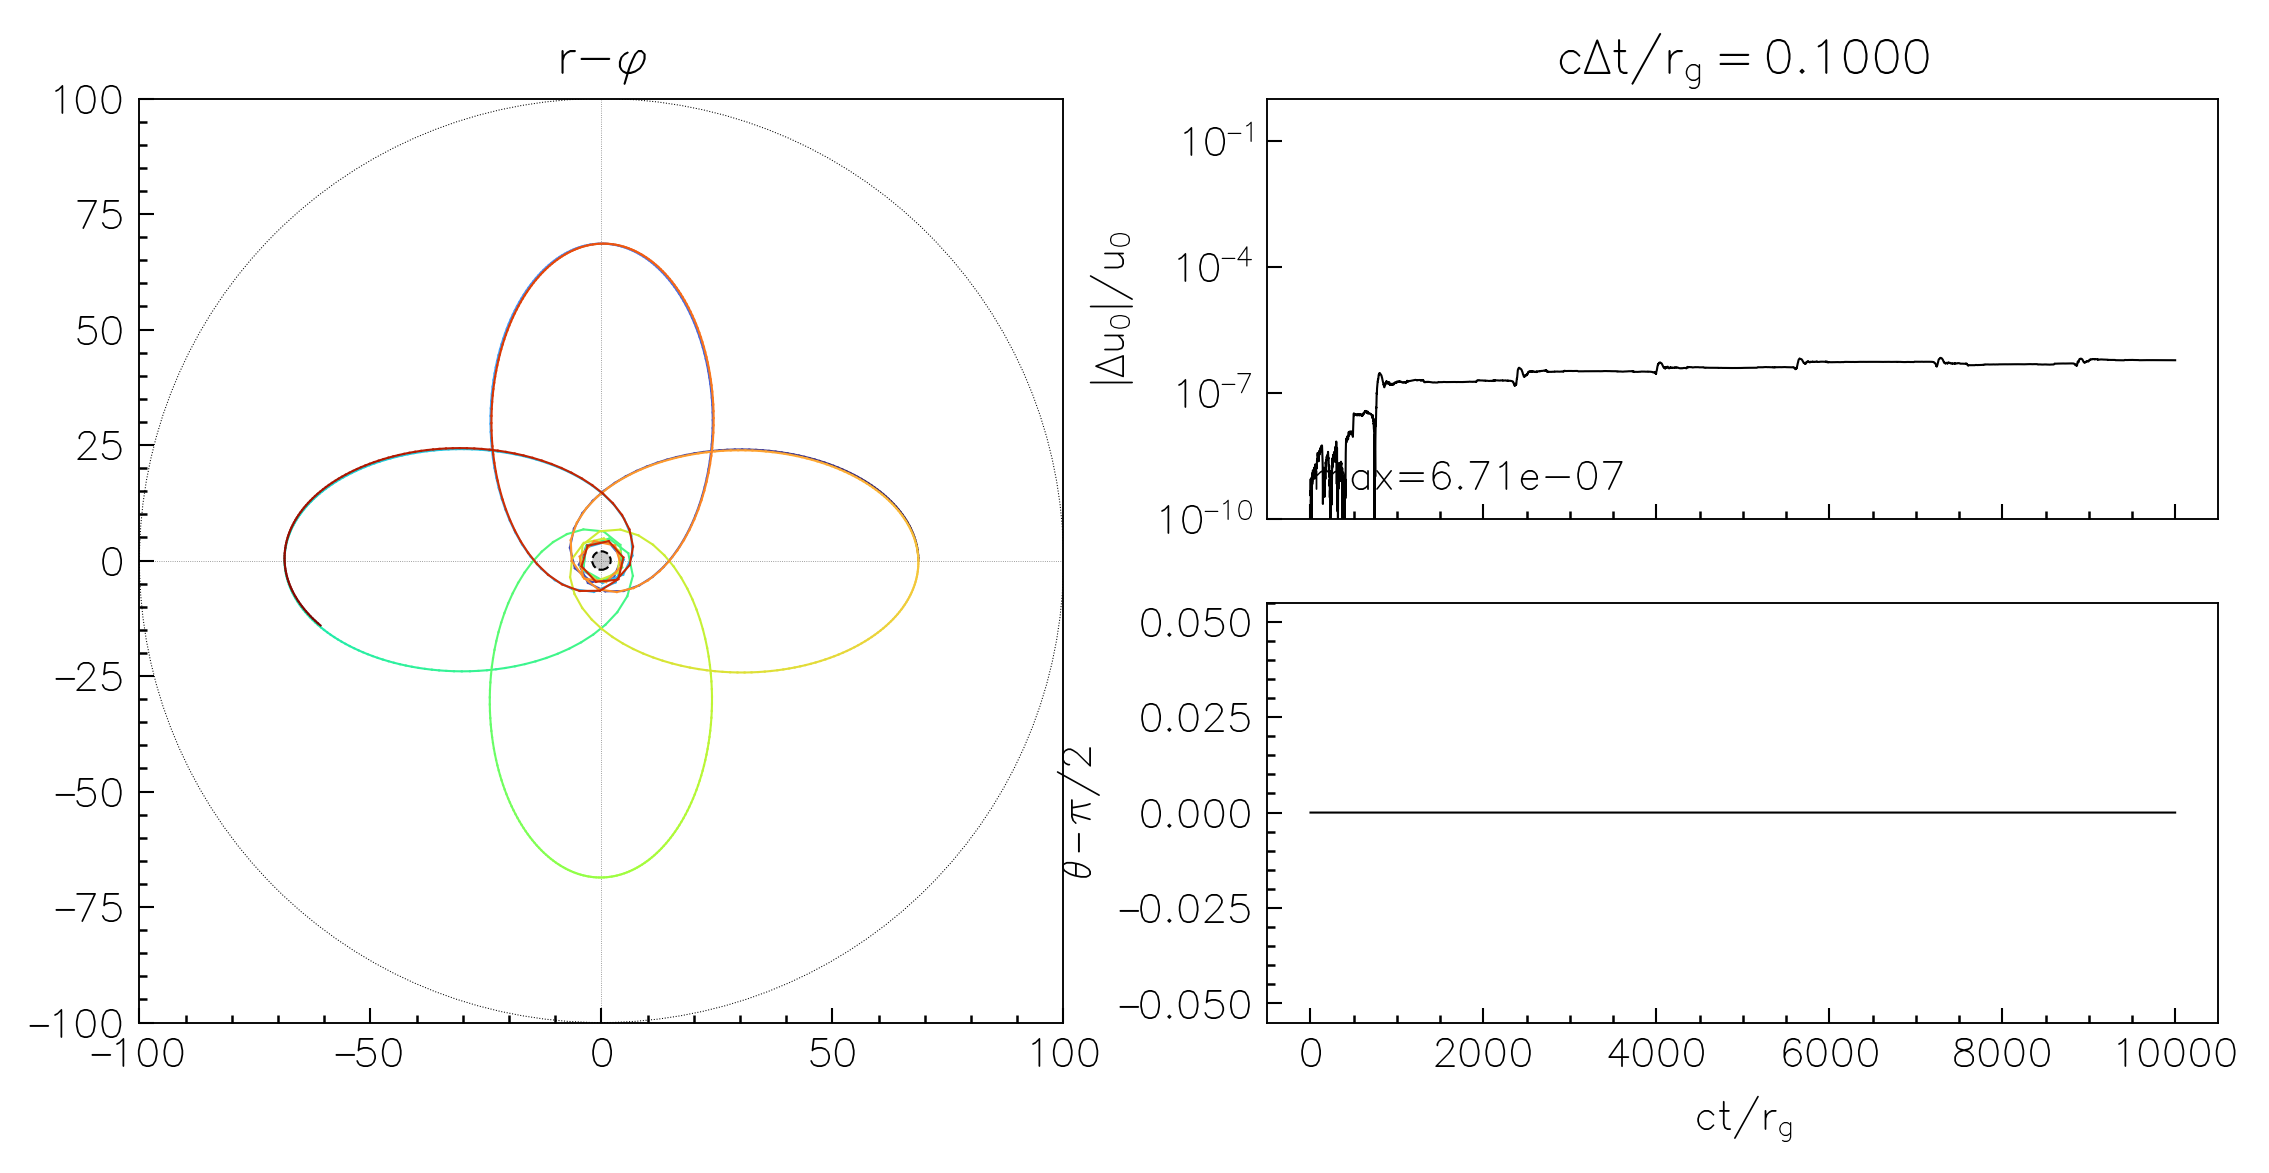

In [6]:
sim = "ks/411_eps1e-2_dt1e-2"
E, L, a = 0.986906, 3.9, 0.0

with nt2r.Data(sim + ".h5") as data:
    rmax = data.attrs["X1"].max()

    fig = plt.figure(figsize=(9, 4), dpi=300)
    ax = fig.add_subplot(121)
    ax.set(aspect="equal")
    xs = (
        data.particles[1].r
        * np.sin(data.particles[1].th)
        * np.cos(data.particles[1].ph)
    )
    ys = (
        data.particles[1].r
        * np.sin(data.particles[1].th)
        * np.sin(data.particles[1].ph)
    )
    zs = data.particles[1].r * np.cos(data.particles[1].th)

    ax.add_artist(
        mpl.patches.Circle(
            (0, 0), data.attrs["rh"], fc="#00000033", ec="k", lw=0.5, ls="--"
        )
    )
    ax.axvline(0, c="gray", lw=0.2, zorder=-10, ls=":")
    ax.axhline(0, c="gray", lw=0.2, zorder=-10, ls=":")
    ax.add_artist(mpl.patches.Circle((0, 0), rmax, fill=None, ec="k", lw=0.25, ls=":"))

    coloredLine(
        xs[::10],
        ys[::10],
        mpl.colormaps["turbo"](data.particles[1].t[::10] / data.particles[1].t.max()),
        ax=ax,
        lw=0.5,
    )
    ax.set(xlim=(-rmax, rmax), ylim=(-rmax, rmax))
    ax.set(title=r"$r$-$\varphi$")

    # u is at t = n - 1/2
    # r is at t = n - 1/2
    u0s = energy(data.particles[1].ur, data.particles[1].uph, data.particles[1].r, a)
    ax = fig.add_subplot(222)

    error = np.squeeze((np.abs(u0s - E) / E).values[()])
    ax.plot(data.particles[1].t, error)
    ax.text(0, 3e-10, f"max={np.max(error):.2e}", va="bottom", ha="left")
    # ax.plot(data.particles[1].t, diffs)
    ax.set_yscale("log")
    ax.set_ylabel(r"$|\Delta u_0| / u_0$")
    ax.set_xticklabels([])
    ax.set_ylim(1e-10, 1)
    ax.set_title(rf"$c\Delta t/r_g={{{data.attrs['Timestep']:.4f}}}$")

    ax = fig.add_subplot(224)

    ax.plot(data.particles[1].t, np.abs(data.particles[1].th - np.pi / 2))
    # ax.set_yscale("log")
    ax.set_ylabel(r"$\theta-\pi/2$")
    ax.set_xlabel(r"$ct/r_g$")
    plt.savefig(f"{sim}.png", bbox_inches="tight", dpi=300)